# Portfolio Optimiser

# User Input

Add the amount to be invested and the stocks to be considered

In [1]:
# Define the parameters
invest = 1000
#stocks = ['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX'] # FAANG Stocks
stocks = ['AAPL', 'AMZN', 'FB', 'NFLX','TSLA','TWTR', 'DIS', 'BABA', 'MSFT','GOOG']

## Import Libraries

Import necessary packages for the optimiser

In [2]:
import pandas as pd
import xlwings as xw
import yfinance as yf

import numpy as np
from numpy import *
from numpy.linalg import multi_dot

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 16, 8

import cufflinks as cf
cf.set_config_file(offline=True)

import scipy.optimize as sco
from scipy.stats import norm

## Pull Data

Add Stock tickers, and time period for historic data. Data will be pulled from yahoo finance.<br> First five rows of data and a normalised plot are displayed to check the download was correct.

In [3]:
#Additional inputs
period = '5y'
numofsimportfolio = 100000

#count of stocks provided
numofasset = len(stocks)

# Fetching data for multiple tickers
# fetch from yahoo
df = yf.download(stocks, period=period, progress=False)['Adj Close']
# fetch from file
#df = pd.read_csv('data/faang_stocks.csv', index_col=0, parse_dates=True,infer_datetime_format=True)['2013':]

# Display the first five rows of the dataframe to check the results. 
df.head()

,AAPL,AMZN,BABA,DIS,FB,GOOG,MSFT,NFLX,TSLA,TWTR
Date,,,,,,,,,,
2015-10-14,25.461657,544.830017,68.540001,99.114899,94.070000,651.159973,42.422577,110.230003,43.375999,29.379999
2015-10-15,25.842854,562.440002,71.779999,101.139755,95.959999,661.739990,42.722469,101.089996,44.262001,29.709999
2015-10-16,25.653408,570.760010,71.989998,101.467850,97.540001,662.200012,43.176865,98.989998,45.402000,31.150000
2015-10-19,25.812820,573.150024,72.650002,102.620903,98.470001,666.099976,43.276833,101.690002,45.619999,30.910000
2015-10-20,26.284117,560.880005,71.790001,102.967751,97.000000,650.280029,43.413151,98.989998,42.605999,30.910000


In [4]:
# Plot Data
df.normalize().iplot(kind='line',title='Normalised Stock Price Plot') # Normalised on a single plot
df.iplot(kind='line', title='Stock Price Plots',subplots=True) # Using separate plots

## Calculate Stats

This Section will calcualte the annualised returns and volatilities given the data provided

### Returns

In [5]:
returns = df.pct_change().fillna(0)
returns.head()

,AAPL,AMZN,BABA,DIS,FB,GOOG,MSFT,NFLX,TSLA,TWTR
Date,,,,,,,,,,
2015-10-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-10-15,0.014971,0.032322,0.047272,0.020429,0.020091,0.016248,0.007069,-0.082918,0.020426,0.011232
2015-10-16,-0.007331,0.014793,0.002926,0.003244,0.016465,0.000695,0.010636,-0.020774,0.025756,0.048469
2015-10-19,0.006214,0.004187,0.009168,0.011364,0.009535,0.005889,0.002315,0.027276,0.004802,-0.007705
2015-10-20,0.018258,-0.021408,-0.011838,0.003380,-0.014928,-0.023750,0.003150,-0.026551,-0.066068,0.000000


In [6]:
# Calculate annual returns
annual_returns = (returns.mean() * 252)
annual_returns

AAPL    0.356339
AMZN    0.409655
BABA    0.351816
DIS     0.082069
FB      0.265403
GOOG    0.209860
MSFT    0.368934
NFLX    0.402448
TSLA    0.637202
TWTR    0.227813
dtype: float64

In [7]:
annual_returns.iplot(kind='bar')

### Volatilities

In [8]:
vols = returns.std()
vols

AAPL    0.018847
AMZN    0.019071
BABA    0.020497
DIS     0.016623
FB      0.020403
GOOG    0.016557
MSFT    0.017565
NFLX    0.025738
TSLA    0.036061
TWTR    0.033041
dtype: float64

In [9]:
# Calculate annualized volatilities
annual_vols = vols*sqrt(252)
annual_vols

AAPL    0.299190
AMZN    0.302737
BABA    0.325385
DIS     0.263883
FB      0.323888
GOOG    0.262835
MSFT    0.278839
NFLX    0.408585
TSLA    0.572448
TWTR    0.524508
dtype: float64

In [10]:
annual_vols.iplot(kind='bar')

### Covariance

In [11]:
# Covariance matrix
returns.cov() * 252

,AAPL,AMZN,BABA,DIS,FB,GOOG,MSFT,NFLX,TSLA,TWTR
AAPL,0.089515,0.052682,0.050370,0.037772,0.055043,0.051768,0.059192,0.054393,0.066536,0.057614
AMZN,0.052682,0.091650,0.052258,0.028178,0.060887,0.054499,0.057414,0.070840,0.064935,0.056417
BABA,0.050370,0.052258,0.105875,0.029363,0.049454,0.047120,0.049460,0.055602,0.061699,0.061324
DIS,0.037772,0.028178,0.029363,0.069635,0.034730,0.035221,0.038091,0.029384,0.043867,0.046971
FB,0.055043,0.060887,0.049454,0.034730,0.104903,0.059202,0.056442,0.061484,0.061412,0.066255
GOOG,0.051768,0.054499,0.047120,0.035221,0.059202,0.069082,0.057511,0.056887,0.056927,0.060204
MSFT,0.059192,0.057414,0.049460,0.038091,0.056442,0.057511,0.077751,0.058971,0.065787,0.061931
NFLX,0.054393,0.070840,0.055602,0.029384,0.061484,0.056887,0.058971,0.166942,0.078144,0.067222
TSLA,0.066536,0.064935,0.061699,0.043867,0.061412,0.056927,0.065787,0.078144,0.327697,0.082318
TWTR,0.057614,0.056417,0.061324,0.046971,0.066255,0.060204,0.061931,0.067222,0.082318,0.275109


## Portfolio Simulation

This section implements a Monte Carlo simulation to generate random portfolio weights and calculate the expected portfolio return, variance and sharpe ratio for every simulated allocation. It will then identify the portfolio with a highest return for per unit of risk.

In [12]:
# Initialize the lists
rets = []; vols = []; wts = []

# Simulate portfolios
for i in range (numofsimportfolio):
    
    # Generate random weights
    weights = random.random(numofasset)[:, newaxis]
    weights /= sum(weights)
    
    # Portfolio statistics
    rets.append(weights.T @ array(annual_returns)[:, newaxis])        
    vols.append(sqrt(multi_dot([weights.T, returns.cov()*252, weights])))
    wts.append(weights.flatten())

# Record values     
port_rets = array(rets).flatten()
port_vols = array(vols).flatten()
port_wts = array(wts)

# Create a dataframe for analysis
mc_df = pd.DataFrame({'returns': port_rets,
                      'volatility': port_vols,
                      'sharpe_ratio': port_rets/port_vols,
                      'weights': list(port_wts)})

# Summary Statistics
mc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
returns,100000.0,0.331197,0.027093,0.217728,0.312658,0.331128,0.349537,0.451147
volatility,100000.0,0.256290,0.011184,0.224461,0.248437,0.255431,0.263121,0.337824
sharpe_ratio,100000.0,1.291798,0.081989,0.887312,1.240428,1.296966,1.349620,1.529129


In [13]:
# Max sharpe ratio portfolio 
msrp = mc_df.iloc[mc_df['sharpe_ratio'].idxmax()]
msrp

returns                                                  0.414577
volatility                                               0.271119
sharpe_ratio                                              1.52913
weights         [0.16574382319798714, 0.17484036763732708, 0.1...
Name: 68165, dtype: object

In [14]:
# Min volatility portfolio 
mvol = mc_df.iloc[mc_df['volatility'].idxmin()]
mvol

returns                                                   0.24791
volatility                                               0.224461
sharpe_ratio                                              1.10447
weights         [0.07456305921319772, 0.009606558507743295, 0....
Name: 71769, dtype: object

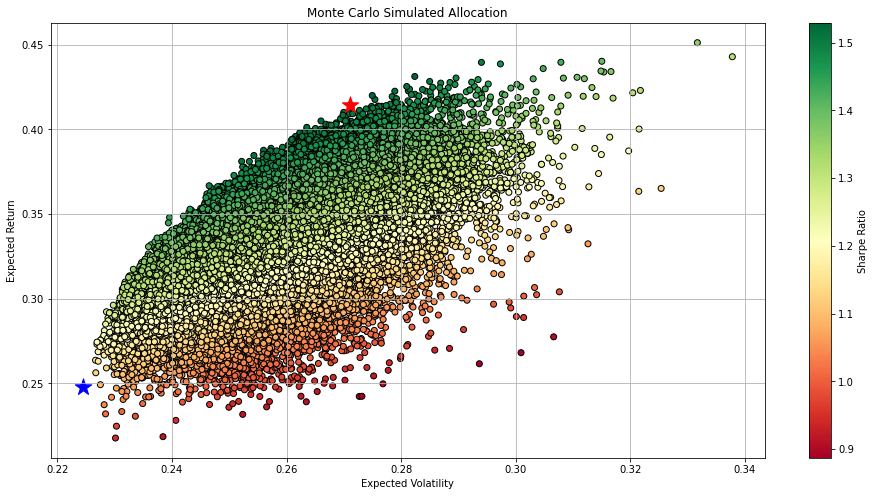

In [15]:
# Visualize the simulated portfolio for risk and return
fig = plt.figure()
ax = plt.axes()

ax.set_title('Monte Carlo Simulated Allocation')

# Simulated portfolios
fig.colorbar(ax.scatter(port_vols, port_rets, c=port_rets / port_vols, 
                        marker='o', cmap='RdYlGn', edgecolors='black'), label='Sharpe Ratio') 

# Maximum sharpe ratio portfolio
ax.scatter(msrp['volatility'], msrp['returns'], c='red', marker='*', s = 300, label='Max Sharpe Ratio')

# Minimum volatility portfolio
ax.scatter(mvol['volatility'], mvol['returns'], c='blue', marker='*', s = 300, label='Min Volatility')

ax.set_xlabel('Expected Volatility')
ax.set_ylabel('Expected Return')
ax.grid(True)

# Results

### Maximum Sharpe ratio

Portfolio with the best return per unit of risk:

In [16]:
# Max sharpe ratio portfolio weights
max_sharpe_port_wts = mc_df['weights'][mc_df['sharpe_ratio'].idxmax()]

# Allocation to achieve max sharpe ratio portfolio
MaxSRWt = dict(zip(stocks,np.around(max_sharpe_port_wts,4)))
MaxSRDf = pd.DataFrame.from_dict(MaxSRWt, orient='index', columns=['Weight'])
MaxSRDf['Amount'] = MaxSRDf.apply(lambda x: x*invest, axis=1)
MaxSRDf

,Weight,Amount
AAPL,0.1657,165.7
AMZN,0.1748,174.8
FB,0.1781,178.1
NFLX,0.0082,8.2
TSLA,0.0030,3.0
TWTR,0.0397,39.7
DIS,0.1188,118.8
BABA,0.1073,107.3
MSFT,0.1902,190.2
GOOG,0.0140,14.0


In [17]:
msrp

returns                                                  0.414577
volatility                                               0.271119
sharpe_ratio                                              1.52913
weights         [0.16574382319798714, 0.17484036763732708, 0.1...
Name: 68165, dtype: object

### Minimum Volatility

Portfolio with the lowest variation:

In [18]:
# Min volatility portfolio weights
min_vol_port_wts = mc_df['weights'][mc_df['volatility'].idxmin()]

# Allocation to achieve min volatility portfolio
MinvolWt = dict(zip(stocks,np.around(min_vol_port_wts,4)))
MinvolDf = pd.DataFrame.from_dict(MinvolWt, orient='index', columns=['Weight'])
MinvolDf['Amount (£)'] = MinvolDf.apply(lambda x: x*invest, axis=1)
MinvolDf

,Weight,Amount (£)
AAPL,0.0746,74.6
AMZN,0.0096,9.6
FB,0.1443,144.3
NFLX,0.3092,309.2
TSLA,0.0384,38.4
TWTR,0.1753,175.3
DIS,0.2067,206.7
BABA,0.0246,24.6
MSFT,0.0102,10.2
GOOG,0.0071,7.1


In [19]:
mvol

returns                                                   0.24791
volatility                                               0.224461
sharpe_ratio                                              1.10447
weights         [0.07456305921319772, 0.009606558507743295, 0....
Name: 71769, dtype: object

# Portfolio Risk

## Value at Risk (VaR)

VaR is defined as the maximum loss with a confidence level over a predetermined period.

In [20]:
msrwts = np.array([*MaxSRWt.values()])[:,np.newaxis]
msr_ret = np.dot(returns,msrwts)
msr_ret.flatten()
msr_mean = msr_ret.mean()
msr_stdev = np.sqrt(multi_dot([msrwts.T, returns.cov(), msrwts]))
msrVaR_95 = norm.ppf(1-0.95,msr_mean,msr_stdev).flatten()[0]

mvwts = np.array([*MinvolWt.values()])[:,np.newaxis]
mv_ret = np.dot(returns,mvwts)
mv_ret.flatten()
mv_mean = mv_ret.mean()
mv_stdev = np.sqrt(multi_dot([mvwts.T, returns.cov(), mvwts]))
mvVaR_95 = norm.ppf(1-0.95,mv_mean,mv_stdev).flatten()[0]

print(f'Maximum Sharpe ratio 5 day Portoflio VaR at 95% confidence level (£): {around(invest * np.sqrt(5) * msrVaR_95,2)}')
print(f'Minimum Volatility 5 day Portoflio VaR at 95% confidence level (£): {around(invest * np.sqrt(5) * mvVaR_95,2)}')

Maximum Sharpe ratio 5 day Portoflio VaR at 95% confidence level (£): -59.13
Minimum Volatility 5 day Portoflio VaR at 95% confidence level (£): -49.81


## Expected Shortfall (ES)

ES is defined as the average loss based on the returns that are lower than the VaR threshold.

In [21]:
msr_es = msr_ret[msr_ret<=msrVaR_95].mean()
mv_es = mv_ret[mv_ret<=mvVaR_95].mean()

print(f'Maximum Sharpe ratio 5 day Expected Shortfall at 95% confidence level (£): {around(invest * np.sqrt(5) * msr_es,2)}')
print(f'Minimum Volatility 5 day Expected Shortfall at 95% confidence level (£): {around(invest * np.sqrt(5) * mv_es,2)}')

Maximum Sharpe ratio 5 day Expected Shortfall at 95% confidence level (£): -88.18
Minimum Volatility 5 day Expected Shortfall at 95% confidence level (£): -79.62


## Portfolio Minimisation

This approach uses the "minimise" function to minimise the -sharpe ratio (equivalent to maximising +sharpe ratio), by changing the weights.

In [22]:
def portfolio_stats(weights):
    
    weights = array(weights)[:,newaxis]
    port_rets = weights.T @ array(returns.mean() * 252)[:,newaxis]    
    port_vols = sqrt(multi_dot([weights.T, returns.cov() * 252, weights])) 
    
    return np.array([port_rets, port_vols, port_rets/port_vols]).flatten()

# Maximizing sharpe ratio
def min_sharpe_ratio(weights):
    return -portfolio_stats(weights)[2]

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(numofasset))
initial_wts = numofasset*[1./numofasset]

# Optimizing for maximum sharpe ratio
opt_sharpe = sco.minimize(min_sharpe_ratio, initial_wts, method='SLSQP', bounds=bnds, constraints=cons)

opt_sharpe

     fun: -1.5804794508099438
     jac: array([ 2.43633986e-05, -4.68194485e-05, -1.79409981e-05,  4.46824178e-01,
        2.81947717e-01,  4.12581265e-01,  8.97049904e-06,  5.58495522e-05,
        7.20471144e-05,  5.33227399e-01])
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([1.17115838e-01, 3.41614989e-01, 1.24366351e-01, 7.86208387e-17,
       1.76589429e-16, 0.00000000e+00, 2.24967306e-01, 2.88141531e-02,
       1.63121364e-01, 6.32631968e-17])

In [23]:
MinvolWt2=dict(zip(stocks,np.around(opt_sharpe['x'],4)))
MinvolDf2= pd.DataFrame.from_dict(MinvolWt2, orient='index', columns=['Weight'])
MinvolDf2['Amount (£)'] = MinvolDf2.apply(lambda x: x*invest, axis=1)
MinvolDf2

,Weight,Amount (£)
AAPL,0.1171,117.1
AMZN,0.3416,341.6
FB,0.1244,124.4
NFLX,0.0000,0.0
TSLA,0.0000,0.0
TWTR,0.0000,0.0
DIS,0.2250,225.0
BABA,0.0288,28.8
MSFT,0.1631,163.1
GOOG,0.0000,0.0


In [24]:
stats = ['Returns', 'Volatility', 'Sharpe Ratio']
dict(zip(stats,np.around(portfolio_stats(opt_sharpe['x']),4)))

{'Returns': 0.424, 'Volatility': 0.2683, 'Sharpe Ratio': 1.5805}

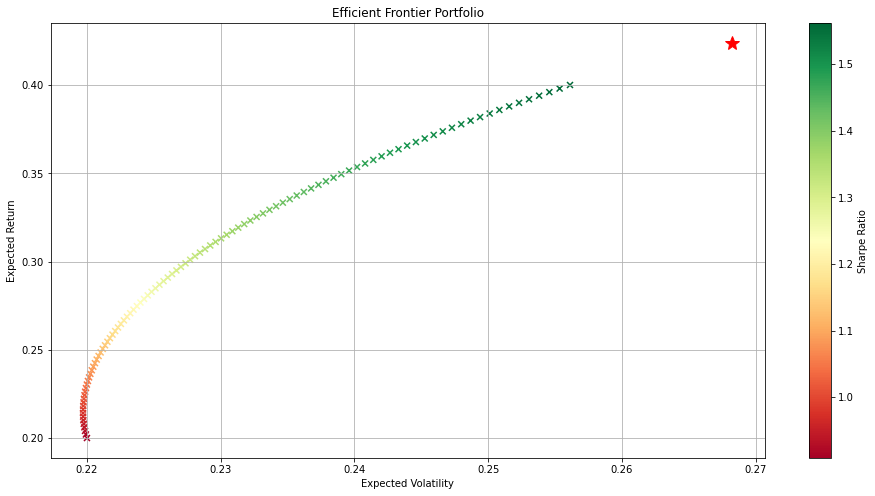

In [25]:
def min_volatility(weights):
    return portfolio_stats(weights)[1]

targetrets = linspace(0.2,0.4,100)
tvols = []

for tr in targetrets:
    # contstraints: return - target return = 0, and sum of weights -1 = 0
    ef_cons = ({'type': 'eq', 'fun': lambda x: portfolio_stats(x)[0] - tr},
               {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    opt_ef = sco.minimize(min_volatility, initial_wts, method='SLSQP', bounds=bnds, constraints=ef_cons)
    
    tvols.append(opt_ef['fun'])

targetvols = array(tvols)

# Visualize the simulated portfolio for risk and return
fig = plt.figure()
ax = plt.axes()

ax.set_title('Efficient Frontier Portfolio')

# Efficient Frontier
fig.colorbar(ax.scatter(targetvols, targetrets, c=targetrets / targetvols, 
                        marker='x', cmap='RdYlGn', edgecolors='black'), label='Sharpe Ratio') 

# Maximum Sharpe Portfolio
ax.plot(portfolio_stats(opt_sharpe['x'])[1], portfolio_stats(opt_sharpe['x'])[0], 'r*', markersize =15.0)


ax.set_xlabel('Expected Volatility')
ax.set_ylabel('Expected Return')
ax.grid(True)